In [1]:
import pandas as pd
import numpy as np
from numpy import array
import xml.etree.ElementTree as ET
import string
#re
import re
#NLTK
import nltk
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk.corpus import stopwords
#Plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS





# Data de entrenamiento

In [2]:

tree = ET.parse('train2.xml')
root = tree.getroot()

In [3]:
train_set = pd.DataFrame({'tweet_id':[],'tweetText':[],'polarity_value':[],'polarity_type':[],'topic':[]})
row=0
for tweet in root:
    tweet_id = 'ID:'+tweet.find('tweetid').text
    tweetText = tweet.find('content').text
    lang = tweet.find('lang').text
    polarity_value = tweet.find('sentiments').find('polarity').find('value').text
    polarity_type = tweet.find('sentiments').find('polarity').find('type').text
    topic = tweet.find('topics').find('topic').text
    
    if lang == 'es':
        train_set.loc[row] = [tweet_id,tweetText,polarity_value,polarity_type,topic]
        row+=1

In [4]:
train_set['set']='train'

In [5]:
#Mostrando la data
train_set.head(10)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N+,AGREEMENT,política,train
4,ID:142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,P+,AGREEMENT,otros,train
5,ID:142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",NONE,AGREEMENT,música,train
6,ID:142483342040907776,Toca @crackoviadeTV3 . Grabación dl especial N...,P+,AGREEMENT,entretenimiento,train
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NONE,AGREEMENT,política,train
8,ID:142494476051562496,Buen día todos! Lo primero mandar un abrazo gr...,P+,AGREEMENT,otros,train
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P+,AGREEMENT,política,train


In [6]:
train_set.columns = ['tweet_id', 'tweetText', 'polarity_value', 'polarity_type', 'topic','set']

In [7]:
train_set.head(4)

,tweet_id,tweetText,polarity_value,polarity_type,topic,set
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros,train
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros,train
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros,train
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N+,AGREEMENT,política,train


In [8]:
train_set.topic.value_counts()

política           2715
otros              1620
entretenimiento    1209
economía            525
música              412
fútbol              225
cine                183
tecnología          144
deportes            101
literatura           84
Name: topic, dtype: int64

In [9]:
train_set.polarity_value.value_counts()

P+      1652
NONE    1482
N       1335
P       1232
N+       847
NEU      670
Name: polarity_value, dtype: int64

In [10]:
train_set = train_set.loc[(train_set.polarity_value == 'P') | (train_set.polarity_value == 'N') ]

# Tweets Peruanos 

In [11]:
tweets=pd.read_json('file.json',lines=True)

tweets['set']='test'
tweets['polarity_value']=np.NaN


In [12]:
#Dimensiones
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype                                 
---  ------           --------------  -----                                 
 0   id               1026 non-null   int64                                 
 1   conversation_id  1026 non-null   int64                                 
 2   created_at       1026 non-null   datetime64[ns, pytz.FixedOffset(-300)]
 3   date             1026 non-null   datetime64[ns]                        
 4   time             1026 non-null   object                                
 5   timezone         1026 non-null   int64                                 
 6   user_id          1026 non-null   int64                                 
 7   username         1026 non-null   object                                
 8   name             1026 non-null   object                                
 9   place            1026 non-null   object  

# Procesando Tweets

In [13]:
processed_tweets= pd.concat([pd.DataFrame({'tweetID':tweets.id, 'tweetText':tweets.tweet,'polarity_value':tweets.polarity_value, 'set':tweets.set}), 
                             pd.DataFrame({'tweetID':train_set.tweet_id, 'tweetText':train_set.tweetText, 'polarity_value':train_set.polarity_value,'set':train_set.set})], ignore_index=True)
processed_tweets['processed_tweet'] = processed_tweets.tweetText
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
3457,ID:186336682067505153,"Vale, lo reconozco, odio madrugar... http://t....",N,train,"Vale, lo reconozco, odio madrugar... http://t...."
1096,ID:143818232397185024,Una vez q ha hablado el protectorado franco-al...,N,train,Una vez q ha hablado el protectorado franco-al...
3034,ID:178223452665298944,Siglo XIX. El director de la Ford en España qu...,N,train,Siglo XIX. El director de la Ford en España qu...
3209,ID:181517986291646468,Felicidades @epicuro7 ;),P,train,Felicidades @epicuro7 ;)


## Hashtags

In [14]:

hash_regex = re.compile(r"#(\w+)")
hstgs = [] # To store the hashtags so we can exclude them from some parts of the analysis
def hash_repl(match):
    _ = '__HASH_'+match.group(1).upper()
    hstgs.append(_)
    return _

## USERNAMES

In [15]:
user_regex = re.compile(r"@(\w+)")
usr_names = [] # To store the user names so we can exclude them from some parts of the analysis
def user_repl(match):
    _ = '__user_'+match.group(1).upper()
    usr_names.append(_)
    return _

## URLs

In [16]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return '__URL_'


## REPETI

In [17]:

rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [18]:
# Test
re.sub(rpt_regex, rpt_repl, "Reppppeated characters in wordsssssssss" )

'Reppeated characters in wordss'

## Puntuacion

In [19]:
# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Punctuations
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#For punctuation replacement
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

## Stemming

In [20]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [21]:
# Test
text = processed_tweets.processed_tweet[55]
print(text)
text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) and (word not in usr_names))]
text = [stemmer.stem(w) for w in text]                
text = " ".join(text)
print('------------------')
print(text)

@MerinoDeLama Tienes el repudio de gran parte de la población peruana. #merinonomerepresenta
------------------
@merinodelam tien repudi gran part poblacion peruana. #merinonomerepresent


In [22]:
def sb_stem(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] #   If we are doing negation analysis, maybe is a better idea to keep the small words (like 'no')
    text = [stemmer.stem(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

In [23]:

def processAll(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = sb_stem(text)    
    return text

In [24]:
d="Aasda!.? @Hola #AeaManito https://facebo.com asd"
processAll(d)

['aasd',
 '__PUNC_EXCL',
 '__PUNC_QUES',
 '__user_HOLA',
 '__HASH_AEAMANITO',
 '__URL_',
 'asd']

# Procesamiento de tweets

In [25]:
processed_tweets['processed_tweet'] = processed_tweets.tweetText.apply(processAll)


In [26]:
processed_tweets.sample(4)

,tweetID,tweetText,polarity_value,set,processed_tweet
2013,ID:162536772981633024,Médicos Sin Fronteras cesa su actividad en las...,N,train,"[medic, sin, fronter, ces, activ, las, carcel,..."
880,1327953420288995329,TW // police brutality // Please help share w...,NaN,test,"[polic, brutality, ple, help, shar, what, happ..."
1414,ID:149975158763958273,Mucho ánimo para los compañeros de ADN,P,train,"[much, anim, par, los, compañer, adn]"
3548,ID:188714489493979139,En el imperio del balompié nunca se pone el gol.,P,train,"[imperi, del, balompi, nunc, pon, gol]"


## Funciones

### Emoticones

In [27]:
# Emoticons
emoticons = \
	[	# For __EMOT_SMILEY
        (' __emoji: U+1F601',	[':-)', ':)', '(:', '(-:', ] )	,\
        # for __EMOT_LAUGH
		(' __emoji: U+1F923',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
        # For __EMOT_LOVE
		(' __emoji: U+2764',		['<3', ':\*', ] )	,\
        # For __EMOT_WINK
		('__emoji: U+1F609',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
        # For __EMOT_FROWN
		(' __emoji: U+2639',		[':-(', ':(', '(:', '(-:', ] )	,\
        # For __EMOT_CRY
		(' __emoji: U+1F622',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

In [28]:
# Test
text = "This is a text with one emoticon :) and another :("
for (repl, regx) in emoticons_regex :
    text = re.sub(regx, ' '+repl+' ', text)
    
print(text)

This is a text with one emoticon   __emoji: U+1F601  and another   __emoji: U+2639 


In [29]:
emojis_db=pd.read_csv('emojis_db_csv.csv')
emojis_db.head()

,emoji_category,number,code,CLDR_Short_Name
0,face-positive,1,U+1F600,grinning face
1,face-positive,2,U+1F601,beaming face with smiling eyes
2,face-positive,3,U+1F602,face with tears of joy
3,face-positive,4,U+1F923,rolling on the floor laughing
4,face-positive,5,U+1F603,grinning face with big eyes


In [30]:
def emojis_unicode(tweet):
    ''' Extracts the emojis on the tweet on Unicode format, also tries to match those in regular format, such as ";)" '''
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)
#     print(tweet)

    tweet_unicode = str(tweet.encode('unicode-escape'))
    tweet_unicode = tweet_unicode.replace('\\\\U000',' __emoji: U+')
#     print(tweet_unicode)
    
    emoji_list = []
#     print(tweet)
    for emoji in range(tweet_unicode.count(' __emoji: ')):
        em = tweet_unicode.split('__emoji: ')[emoji+1].split()[0]
        em = em[:7] # the len of the emoji in unicode is between 6 and 7
        emoji_list.append(em.upper())
    return emoji_list

In [31]:
# Test
text = "😡🤣😂"
emojis_unicode(text)

['U+1F621', 'U+1F923', 'U+1F602']

In [32]:
def emoji_category(emojis):
    categories = []
    for i in range(len(emojis)):
        # print(emojis[i])
        try:
            categories.append(emojis_db.loc[emojis_db.code == emojis[i]].emoji_category.values[0])
        except:
            try:
                _ = emojis[i].split('+')[1] + '+'
                categories.append(emojis_db[emojis_db.code.str.contains(_)].emoji_category.values[0])
            except:
                categories.append('other')
    if len(categories) < 1:
        categories.append('no_emojis')
    return categories

emoji_category(emojis_unicode(text))

['face-negative', 'face-positive', 'face-positive']

In [33]:

# Wrapper function that encloses all the n-grams procedures
def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

### Negacion

In [34]:
negtn_regex = re.compile( r"""(?:
    ^(?:nunca|no|nada|ningún|ninguno|ninguna|tampoco|
        nunc|nad|ningun|tampoc
    )$
)
|
n't
""", re.X)

def get_negation_features(words):
    INF = 0.0
    negtn = [ bool(negtn_regex.search(w)) for w in words ]

    left = [0.0] * len(words)
    prev = 0.0
    for i in range(0,len(words)):
        if( negtn[i] ):
            prev = 1.0
        left[i] = prev
        prev = max( 0.0, prev-0.1)

    right = [0.0] * len(words)
    prev = 0.0
    for i in reversed(range(0,len(words))):
        if( negtn[i] ):
            prev = 1.0
        right[i] = prev
        prev = max( 0.0, prev-0.1)

    return dict( zip(
                    ['neg_l('+w+')' for w in  words] + ['neg_r('+w+')' for w in  words],
                    left + right ) )

In [35]:
# Test
text = ["Este","tweet", "no", "es", "positivo"]
get_negation_features(text)


{'neg_l(Este)': 0.0,
 'neg_l(tweet)': 0.0,
 'neg_l(no)': 1.0,
 'neg_l(es)': 0.9,
 'neg_l(positivo)': 0.8,
 'neg_r(Este)': 0.8,
 'neg_r(tweet)': 0.9,
 'neg_r(no)': 1.0,
 'neg_r(es)': 0.0,
 'neg_r(positivo)': 0.0}

# STOP WORDS

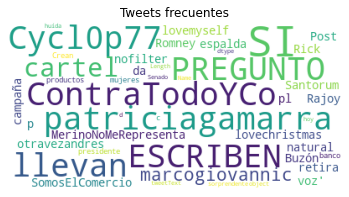

In [36]:
punctuation = list(string.punctuation)
stop = stopwords.words('spanish') + punctuation + ['rt', 'via']
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=150,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(processed_tweets['tweetText']))
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.title("Tweets frecuentes")
plt.show()